In [1]:
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from TrainVoxelmorph import VoxelmorphTF
#from trainPytorch import VoxelmorphTorch
from DataHandler import DataHandler
import SimpleITK as sitk
import os
import voxelmorph as vxm
#import tensorflow as tf
#import torch as th
from DataHandler import DataHandler
import pickle

In [2]:
def get_moved_points(points: np.array, displacement: sitk.Image) -> np.array:
    displacement_copy = displacement.__copy__()
    displacement_transform = sitk.DisplacementFieldTransform(displacement_copy)
    moved_points = [displacement_transform.TransformPoint(point) for point in points]
    return moved_points

def get_landmarks(fixed_image_path: str, indexing: str = 'zyx', continuous = False, preResample = False):
    model_name = os.path.basename(fixed_image_path).replace('_atn_3.nrrd', '')
    if preResample: 
        loaded_points = pickle.load(open(f'/home/cschellenberger/Documents/vectorPickles/{model_name}_vec_frame1_to_frame2.p', "rb"))
        moving_landmarks = np.array([(float(loaded_points[idx]['1X']), float(loaded_points[idx]['1Y']), float(loaded_points[idx]['1Z'])) for (idx, _) in enumerate(loaded_points)])
        fixed_landmarks = np.array([(float(loaded_points[idx]['2X']), float(loaded_points[idx]['2Y']), float(loaded_points[idx]['2Z'])) for (idx, _) in enumerate(loaded_points)])
    else: 
        #if continuous: loaded_points = pickle.load(open(f'/home/cschellenberger/Documents/vectorPickles/CT_points_t1_t3_withRegion_Continuous/{model_name}_idx.p', "rb"))
        if continuous: loaded_points = pickle.load(open(f'/home/cschellenberger/Documents/vectorPickles/CT_points_t1_t3_withRegion_Spacing2/{model_name}_idx.p', "rb"))
        else: loaded_points = pickle.load(open(f'/home/cschellenberger/Documents/vectorPickles/CT_points_t1_t3_withRegion/{model_name}_idx.p', "rb"))
        moving_landmarks = np.array(loaded_points['t1'])
        fixed_landmarks = np.array(loaded_points['t3'])
    regions = np.array(loaded_points['Region'])
    if indexing == 'xzy':
        # swap columns because numpy and vxm use zyx indexing and the data uses xyz indexing
        moving_landmarks[:, [1, 2]] = moving_landmarks[:, [2, 1]]
        fixed_landmarks[:, [1, 2]] = fixed_landmarks[:, [2, 1]]
    elif indexing == 'zyx':
        # swap columns because numpy and vxm use zyx indexing and the data uses xyz indexing
        moving_landmarks[:, [0, 2]] = moving_landmarks[:, [2, 0]]
        fixed_landmarks[:, [0, 2]] = fixed_landmarks[:, [2, 0]]
    elif indexing == 'yxz':
        # swap columns because numpy and vxm use zyx indexing and the data uses xyz indexing
        moving_landmarks[:, [0, 1]] = moving_landmarks[:, [1, 0]]
        fixed_landmarks[:, [0, 1]] = fixed_landmarks[:, [1, 0]]
    else: assert indexing == 'xyz', f'indexing can only be xyz or zyx. Got: {indexing}'
    return moving_landmarks.astype(np.float64), fixed_landmarks.astype(np.float64), regions

def get_landmarks_unresampled(fixed_image_path: str, indexing: str = 'zyx'):
    model_name = os.path.basename(fixed_image_path).replace('_atn_3.nrrd', '')
    loaded_points = pickle.load(open(f'/home/cschellenberger/Documents/vectorPickles/{model_name}_vec_frame1_to_frame2.p', "rb"))
    moving_landmarks = np.array([[p['1X'], p['1Y'], p['1Z']] for p in loaded_points])
    fixed_landmarks = np.array([[p['2X'], p['2Y'], p['2Z']] for p in loaded_points])
    regions = np.array(loaded_points['Region'])
    if indexing == 'zyx':
        # swap columns because numpy and vxm use zyx indexing and the data uses xyz indexing
        moving_landmarks[:, [0, 2]] = moving_landmarks[:, [2, 0]]
        fixed_landmarks[:, [0, 2]] = fixed_landmarks[:, [2, 0]]
    if indexing == 'zxy':
        # swap columns because numpy and vxm use zyx indexing and the data uses xyz indexing
        moving_landmarks[:, [0, 1]] = moving_landmarks[:, [1, 0]]
        fixed_landmarks[:, [0, 1]] = fixed_landmarks[:, [1, 0]]
        moving_landmarks[:, [0, 2]] = moving_landmarks[:, [2, 0]]
        fixed_landmarks[:, [0, 2]] = fixed_landmarks[:, [2, 0]]
    elif indexing == 'yxz':
        # swap columns because numpy and vxm use zyx indexing and the data uses xyz indexing
        moving_landmarks[:, [0, 1]] = moving_landmarks[:, [1, 0]]
        fixed_landmarks[:, [0, 1]] = fixed_landmarks[:, [1, 0]]
    else: assert indexing == 'xyz', f'indexing can only be xyz or zyx. Got: {indexing}'
    return moving_landmarks.astype(np.float64), fixed_landmarks.astype(np.float64), regions

In [3]:
idx = 0
downSize = 1
dh = DataHandler(val_images=12)
weights_path = '/home/cschellenberger/Documents/scripts/models/synthetic/l10011000_st10_lr0_001_bat4/weights.h5'
weights_path = '/home/cschellenberger/Documents/scripts/models/synthetic/intsteps4_secondTrain_1000_st10_lr0_0001_bat4/bestWeights.h5'
#weights_path = '/home/cschellenberger/Documents/scripts/models/synthetic/l1l2Red500_st24_lr0_0002_bat4/bestWeights.h5'
#weights_path = '/home/cschellenberger/Documents/scripts/models/synthetic/vxmth_NewNMIDataRight250_st11_lr0_001_bat4_final_lossnan/model.pt'
weights_path = '/home/cschellenberger/Documents/scripts/models/synthetic/newT3_best_localmi_reg001_08_2nd_1000_st43_lr1e-05_bat1/bestWeights.h5'
# dh.get_synthetic_data(
#     fixed_path='/home/cschellenberger/datam2olie/synthetic/orig/t3/Synthetic_CT/',
#     moving_path='/home/cschellenberger/datam2olie/synthetic/orig/t1/Synthetic_MR/')
dh.get_synthetic_data(
    fixed_path='/home/cschellenberger/Documents/newT3Resample',
    moving_path='/home/cschellenberger/Documents/T1ResampledSpacing2')
moving_image_paths = dh.x_val
fixed_image_paths = dh.y_val
moving_image = sitk.ReadImage(moving_image_paths[idx])
#!!!! RANDOM IMAGE !!!!
rand = np.random.rand(128, 256, 256)
moving_image = sitk.GetImageFromArray(rand)
## !!!! !!!!!!
fixed_image = sitk.ReadImage(fixed_image_paths[idx])
#moving_image = sitk.Cast(moving_image, sitk.sitkFloat32)
#fixed_image = sitk.Cast(fixed_image, sitk.sitkFloat32)
nb_features = [[16, 32, 32, 32], [32, 32, 32, 32, 32, 16, 16]]
##nb_features = [[16, 16, 32, 32], [32, 32, 32, 16, 16]]
#nb_features = [[16, 16, 32, 32], [32, 32, 16, 16]]
device = '/cpu:0'
imgReg = VoxelmorphTF(weights_path, fixed_image, nb_features, downSize)
#imgReg = VoxelmorphTorch(weights_path, fixed_image, nb_features)
moved_img, displacement_np, time = imgReg.register_images(moving_image, fixed_image, device)

2022-05-23 14:17:29.600941: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-23 14:17:33.445287: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:214] Using CUDA malloc Async allocator for GPU: 0
2022-05-23 14:17:33.447012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45742 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2022-05-23 14:17:33.450758: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:214] Using CUDA malloc Async allocator for GPU: 1
2022-05-23 14:17:33.451983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:

In [5]:
displacement_np.shape

(1, 128, 256, 256, 3)

In [18]:
mdis = 0
for idx in range(1):
    moving_image = sitk.ReadImage(moving_image_paths[idx])
    fixed_image = sitk.ReadImage(fixed_image_paths[idx])
    moving_image = sitk.Cast(moving_image, sitk.sitkFloat32)
    fixed_image = sitk.Cast(fixed_image, sitk.sitkFloat32)
    moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[idx], indexing='xyz', continuous = True)
    #!!!! RANDOM IMAGE !!!!
    #rand = np.random.rand(128, 256, 256)
    #moving_image = sitk.GetImageFromArray(rand)
    ## !!!! !!!!!!
    moved_image_np, displacement_np, time = imgReg.register_images(moving_image, fixed_image, device)
    displacement = displacement_np.squeeze() * downSize
    displacement[:,:,:,[0,2]] = displacement[:,:,:,[2,0]]
    displacement = sitk.GetImageFromArray(displacement.astype(np.float64), isVector=True)
    #displacement = sitk.GetImageFromArray(displacement_np.permute(0, 2, 3, 4, 1).squeeze().cpu().detach().numpy().astype(np.float64), isVector=True)
    moved_landmarks = get_moved_points(fixed_landmarks, displacement)
    df = pd.DataFrame()
    moving_landmarks = np.transpose(moving_landmarks)
    fixed_landmarks = np.transpose(fixed_landmarks)
    moved_landmarks = np.transpose(moved_landmarks)
    df['t1X'] = moving_landmarks[0]
    df['t1Y'] = moving_landmarks[1]
    df['t1Z'] = moving_landmarks[2]
    df['t3X'] = fixed_landmarks[0]
    df['t3Y'] = fixed_landmarks[1]
    df['t3Z'] = fixed_landmarks[2]
    df['Region'] = regions
    df['evalX'] = moved_landmarks[0]
    df['evalY'] = moved_landmarks[1]
    df['evalZ'] = moved_landmarks[2]
    p1 = np.array([df['evalX'], df['evalY'], df['evalZ']])
    p2 = np.array([df['t1X'], df['t1Y'], df['t1Z']])
    p3 = np.array([df['t3X'], df['t3Y'], df['t3Z']])
    squared_dist = np.sum((p1 - p2) ** 2, axis=0)
    squared_dist_prereg = np.sum((p2 - p3) ** 2, axis=0)
    df['dist'] = np.sqrt(squared_dist)
    df['pre_dist'] = np.sqrt(squared_dist_prereg)
    dists = df.groupby(df['Region'])['dist'].sum() / df['Region'].value_counts()
    mdis += df['dist'].mean()
    #pickle.dump(df, open(f"./results/vxmLuca/{idx}.p", "wb"))
print(mdis / len(dh.x_val))

0.20833164308820562


In [19]:
mdis

2.4999797170584674

In [21]:
dis = df['dist'].groupby(df['Region']).mean().sort_values(ascending=False)
print(dis[dis.index.str.contains('liver')])

Region
known_vector_liver                   1.670021
known_vector_liver_veins_sup_port    1.435394
known_vector_liver_veins_hep         1.328974
known_vector_liver_veins_port        0.944214
Name: dist, dtype: float64


In [ ]:
#luca vmxtf random moving: 15.27717557899466
#nmi: 18.554778350471803
# 9.787027798411502

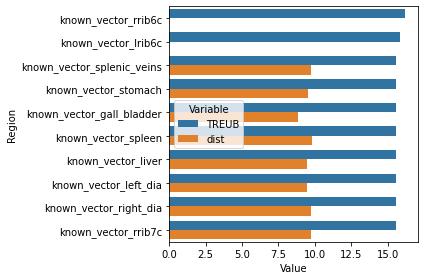

8.251202848535732


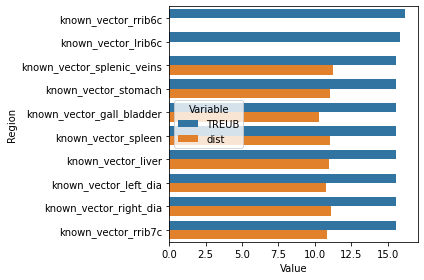

9.542211390422496


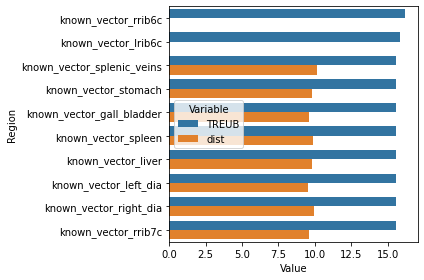

8.79269108012527


In [17]:
for model in ["vxmTf", "vxmTh", "vxmLuca"]:
    resDf = pickle.load(open(f"./results/{model}/{0}.p", "rb"))
    for idx in range(1, 12):
        df = pickle.load(open(f"./results/{model}/{idx}.p", "rb"))
        resDf['dist'] += df['dist']
    resDf['dist'] /= 12
    p1 = np.array([resDf['t3X'], resDf['t3Y'], resDf['t3Z']])
    p2 = np.array([resDf['t1X'], resDf['t1Y'], resDf['t1Z']])
    squared_dist = np.sum((p1 - p2) ** 2, axis=0)
    resDf['TREUB'] = np.sqrt(squared_dist)
    tidy = pd.DataFrame()
    tidy['Region'] = resDf['Region']
    tidy['TREUB'] = resDf['TREUB']
    tidy['dist'] = resDf['dist']
    tidy = tidy.melt(id_vars='Region').rename(columns=str.title)
    dists = resDf.groupby(resDf['Region'])['TREUB'].sum() / resDf['Region'].value_counts()
    dists = dists.sort_values(ascending=False)
    ax = sns.barplot(x = 'Value', y = 'Region', hue = 'Variable', data = tidy, order = dists.index[:10], errwidth = 0)
    plt.tight_layout()
    plt.show()
    print(resDf['dist'].mean())

In [18]:
print(resDf['TREUB'].mean())

9.787027798411502


In [ ]:
p1 = np.array([df['evalX'], df['evalY'], df['evalZ']])
p2 = np.array([df['t1X'], df['t1Y'], df['t1Z']])
squared_dist = np.sum((p1 - p2) ** 2, axis=0)
df['dist'] = np.sqrt(squared_dist)
dists = df.groupby(df['Region'])['dist'].sum() / df['Region'].value_counts()
dists = dists.sort_values(ascending=False)
ax = sns.barplot(y = df['Region'], x = df['dist'], order = dists.index[:10], errwidth = 0)
plt.tight_layout()
plt.show()

In [ ]:
moving_image_paths = dh.x_val
fixed_image_paths = dh.y_val
mean = 0
for i in range(len(moving_image_paths)):       
        moving_image = sitk.ReadImage(moving_image_paths[i])
        fixed_image = sitk.ReadImage(fixed_image_paths[i])
        moving_image = sitk.Cast(moving_image, sitk.sitkFloat32)
        fixed_image = sitk.Cast(fixed_image, sitk.sitkFloat32)
        moved_image_np, displacement_np, time = framework.register_images(
                fixed_image=fixed_image,
                moving_image=moving_image,
                weights_path=model_path,
                nb_features=nb_features)
        displacement = displacement_np.squeeze()
        displacement[:,:,:,[0,2]] = displacement[:,:,:,[2,0]]
        #displacement = 1.8 * displacement
        moved_image = moved_image_np.squeeze()
        moved_image = sitk.GetImageFromArray(moved_image)
        displacement = sitk.GetImageFromArray(displacement, isVector=True)
        displacement.SetSpacing(fixed_image.GetSpacing())
        displacement.SetOrigin(fixed_image.GetOrigin())
        displacement.SetDirection(fixed_image.GetDirection())
        moved_image.SetSpacing(fixed_image.GetSpacing())
        moved_image.SetOrigin(fixed_image.GetOrigin())
        moved_image.SetDirection(fixed_image.GetDirection())
        try: moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[i], indexing='xyz', MR = False)
        except: pass
        moved_landmarks = get_moved_points(fixed_landmarks, displacement)
        df = pd.DataFrame()
        df['t1X'] = [x[0] for x in moving_landmarks]
        df['t1Y'] = [x[1] for x in moving_landmarks]
        df['t1Z'] = [x[2] for x in moving_landmarks]
        df['t3X'] = [x[0] for x in fixed_landmarks]
        df['t3Y'] = [x[1] for x in fixed_landmarks]
        df['t3Z'] = [x[2] for x in fixed_landmarks]
        df['Region'] = regions
        df['evalX'] = [x[0] for x in moved_landmarks]
        df['evalY'] = [x[1] for x in moved_landmarks]
        df['evalZ'] = [x[2] for x in moved_landmarks]
        p1 = np.array([df['evalX'], df['evalY'], df['evalZ']])
        p2 = np.array([df['t1X'], df['t1Y'], df['t1Z']])
        squared_dist = np.sum((p1 - p2) ** 2, axis=0)
        df['dist'] = np.sqrt(squared_dist)
        dists = df.groupby(df['Region'])['dist'].sum() / df['Region'].value_counts()
        mean += df['dist'].mean()

In [ ]:
print(mean / len(moving_image_paths))

In [ ]:
nmean = 0
for i in range(len(moving_image_paths)):       
        try: moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[i], indexing='xyz', MR = False)
        except: pass
        df = pd.DataFrame()
        df['t1X'] = [x[0] for x in moving_landmarks]
        df['t1Y'] = [x[1] for x in moving_landmarks]
        df['t1Z'] = [x[2] for x in moving_landmarks]
        df['t3X'] = [x[0] for x in fixed_landmarks]
        df['t3Y'] = [x[1] for x in fixed_landmarks]
        df['t3Z'] = [x[2] for x in fixed_landmarks]
        p1 = np.array([df['t1X'], df['t1Y'], df['t1Z']])
        p2 = np.array([df['t3X'], df['t3Y'], df['t3Z']])
        squared_dist = np.sum((p1 - p2) ** 2, axis=0)
        df['dist'] = np.sqrt(squared_dist)
        nmean += df['dist'].mean()

In [45]:
# *1.8
def get_moved_image(image: sitk.Image, displacement: sitk.Image) -> np.array:
    resampler = sitk.ResampleImageFilter()
    #displacement_copy = displacement.__copy__()
    #displacement_copy = displacement_copy * 1.8
    displacement_transform = sitk.DisplacementFieldTransform(sitk.Cast(displacement, sitk.sitkVectorFloat64))
    ##ref übergeben
    resampler.SetReferenceImage(image)
    resampler.SetTransform(displacement_transform)
    return resampler.Execute(image)

In [48]:
from pyM2aia import M2aiaOnlineHelper
fixedDisp = get_moved_image(fixed_image, displacement)
movingDisp = get_moved_image(moving_image, displacement)
M2aiaHelper = M2aiaOnlineHelper("ipynbViewer", "jtfc.de:5050/m2aia/m2aia-no-vnc:with_exit", "8899")
with M2aiaHelper as helper:
    helper.show({"moved": moved_img, "fixedDisp": fixedDisp, "movingDisp": movingDisp, "fixed": fixed_image, "moving": moving_image})

You can find your images @  http://141.19.142.80:8899



In [47]:
displacement = displacement_np.squeeze()
#displacement[:,:,:,[0,2]] = displacement[:,:,:,[2,0]]
#displacement = 1.8 * displacement
displacement = sitk.GetImageFromArray(displacement, isVector=True)
displacement.SetSpacing(fixed_image.GetSpacing())
displacement.SetOrigin(fixed_image.GetOrigin())